# Objective

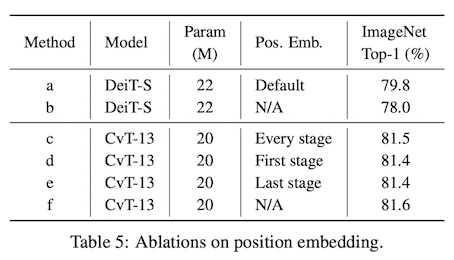

- By tweaking the presence or absence of Position Embedding in the model, we prove that the Convolutional Token Embedding of CvT is completely replacing the Position Embedding.

- For conventional Vision Transformer models(in this experiment, the model is DeiT-S) that recognize images through Position Embedding, performance is reduced when Position Embedding is removed, but for CvT, there is no significant difference in performance.

- DeiT-S and CvT-13 model is trained on Imagenette2 train dataset which is subset of ImageNet, and tested on Imagenette2 test dataset.

## All of these codes are not in the paper. To verify the paper's experiment, I reproduced the codes by referring to the content learned in this course and the codes in the references.

## Setup Environment

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


 - To use DeiT-S Model, we need to download some files
 - Please install and unzip the github zip file using below codes
 - https://github.com/facebookresearch/deit

In [4]:
cd /content/gdrive/MyDrive/FinalProject/AblationPosEmb

/content/gdrive/MyDrive/FinalProject/AblationPosEmb


In [ ]:
!git clone https://github.com/facebookresearch/deit.git

Cloning into 'deit'...
remote: Enumerating objects: 355, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 355 (delta 8), reused 22 (delta 7), pack-reused 328
Receiving objects: 100% (355/355), 5.63 MiB | 13.25 MiB/s, done.
Resolving deltas: 100% (192/192), done.


In [5]:
cd /content/gdrive/MyDrive/FinalProject/AblationPosEmb/deit

/content/gdrive/MyDrive/FinalProject/AblationPosEmb/deit


In [6]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.7 MB 4.2 kB/s 
     |████████████████████████████████| 12.7 MB 95.6 MB/s 
     |████████████████████████████████| 244 kB 97.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.7.0 which is incompatible.


In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import torch.utils.data as data

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Download the Custom Dataset (Imagenette2)
 - subset of 10 easily classified classes from Imagenet
 - Please download and unzip the file using below code
 - https://github.com/fastai/imagenette

In [9]:
import os

os.makedirs('/content/gdrive/MyDrive/FinalProject/CvT-main/DATASET/imagenette2', exist_ok=True)

In [10]:
cd /content/gdrive/MyDrive/FinalProject/CvT-main/DATASET/imagenette2

/content/gdrive/MyDrive/FinalProject/CvT-main/DATASET/imagenette2


In [ ]:
# Downloaded the imagenet subset from fastai 
# Takes about 40 sec
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz

--2022-05-27 11:23:14--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.103.126
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.103.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1557161267 (1.5G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  34.3MB/s    in 51s     

2022-05-27 11:24:06 (28.9 MB/s) - ‘imagenette2.tgz’ saved [1557161267/1557161267]



In [ ]:
# Unzip
# Takes about 20 sec

!tar -xvzf imagenette2.tgz

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
imagenette2/train/n03888257/n03888257_16077.JPEG
imagenette2/train/n03888257/n03888257_23339.JPEG
imagenette2/train/n03888257/n03888257_44204.JPEG
imagenette2/train/n03888257/n03888257_61633.JPEG
imagenette2/train/n03888257/n03888257_15067.JPEG
imagenette2/train/n03888257/n03888257_75365.JPEG
imagenette2/train/n03888257/n03888257_63966.JPEG
imagenette2/train/n03888257/n03888257_3927.JPEG
imagenette2/train/n03888257/n03888257_20684.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2/train/n03888257/n03888257_14016.JPEG
imagenette2/train/n03888257/n03888257_37776.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2/train/n03888257/n03888257_17513.JPEG
imagenette2/train/n03888257/n03888257_17143.JPEG
imagenette2/train/n03888257/n03888257_6738.JPEG
imagenette2/train/n03888257/n03888257_4355.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00030583.JPEG
imagenette2/train/n03888257/n03888257_18127.JPEG
imagenette2/

## Load the Imagenette2

In [11]:
# Hyper parameters
batch_size = 16
num_classes = 10
num_epochs = 20

In [12]:
TRAIN_DATA_PATH = "/content/gdrive/MyDrive/FinalProject/CvT-main/DATASET/imagenette2/imagenette2/train/"
TEST_DATA_PATH = "/content/gdrive/MyDrive/FinalProject/CvT-main/DATASET/imagenette2/imagenette2/val/"

In [13]:
import glob
import cv2
import os
import numpy as np
import torch
import torch.nn
import torchvision
import torchvision.utils
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from PIL import Image
import matplotlib.pyplot as plt

#### Load Data from Local File

In [14]:
def Data(path):
    # Retrieve the list of ALL folders and files inside the base folder
    file_list = glob.glob(path + "*") # 10 folders in path directory

    init_data = []
    # Create a list that would contain the paths to all the images in the dataset
    for class_path in file_list:
        class_name = class_path.split("/")[-1] # extract the class name.
        # Retrieve each image in their folders
        for img_path in glob.glob(class_path + "/*.JPEG"): # for each file with the extension ".JPEG"
            # Check for problematic images
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)                 
            if type(img) is np.ndarray:
                if img.size == 0:
                    continue
            if img is None:
                continue
            init_data.append([img_path, class_name]) # append image file path to init_data list, and its class name

    return init_data

#### Data to Dataset

In [15]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        # Dictionary containing mapping between string and number (class label)
        self.class_map = {"n01440764" : 0, "n02102040": 1, "n02979186":2, "n03000684":3, 
                          "n03028079": 4, "n03394916":5, "n03417042":6, "n03425413":7, 
                          "n03445777":8, "n03888257":9}
        # Set image dimensions
        self.img_dim = (224, 224) 
        # Perform any transformations
        self.transform = transform

    def __len__(self):
        return len(self.data)

    # This function is called when an element of this class is accessed via dataset[index]
    def __getitem__(self, index):
        # Get image path and class name
        img_path, class_name = self.data[index] # tuple from __init__()
        # Obtain the image from its path and resize it to the required dimension
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name] # get the class label
        pil_img=Image.fromarray(img) # convert ndarray to PIL
        # Perform transforms if there are any
        if self.transform:
            img_tensor = self.transform(pil_img)
        # Convert class label to a tensor
        class_id = torch.tensor(class_id) 

        return img_tensor, class_id

In [16]:
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

classes = ('tench', 'English springer', 'cassette player', 'chain saw', 'church', 
           'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute')

In [17]:
train_data = Data(TRAIN_DATA_PATH) # Data loaded from TRAIN_DATA_PATH
train_set = CustomDataset(train_data, transform = train_transform) # Dataset consisted of train_data
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [18]:
test_data = Data(TEST_DATA_PATH) # Data loaded from TRAIN_DATA_PATH
test_set = CustomDataset(test_data, transform = test_transform) # Dataset consisted of train_data
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [19]:
batch = next(iter(train_loader))

images, labels = batch

print(images.shape)
print(labels)

torch.Size([16, 3, 224, 224])
tensor([4, 5, 5, 9, 4, 6, 6, 4, 5, 6, 0, 4, 5, 5, 9, 2])


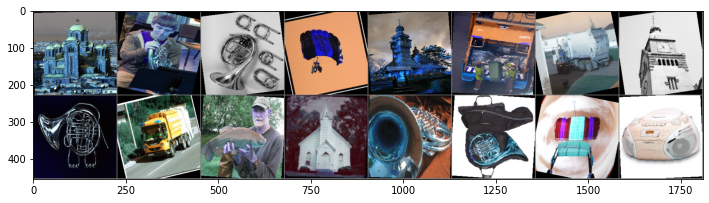

	church 	French horn 	French horn 	parachute 	church 	garbage truck 	garbage truck 	church 	French horn 	garbage truck 	tench 	church 	French horn 	French horn 	parachute 	cassette player


In [20]:
from PIL import Image
import matplotlib.pyplot as plt
# Inverse the normalisation
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def imshow(img):
    img = inverse_normalize(tensor=img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  
    npimg = img.numpy()
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(batch_size)))

# Define Model

 - We modified the original timm file. (In colab environment, we couln't use some library and import grammer. Thus, we simply replaced it)
 - So, Please use the modified file in our drive (/content/gdrive/MyDrive/FinalProject/AblationPosEmb/timm)
 - When you download this folder, please save in /content/gdrive/MyDrive/FinalProject/AblationPosEmb
 - https://github.com/rwightman/pytorch-image-models/tree/master/timm

In [21]:
cd /content/gdrive/MyDrive/FinalProject/AblationPosEmb/timm/models/

/content/gdrive/MyDrive/FinalProject/AblationPosEmb/timm/models


In [22]:
from layers import PatchEmbed, Mlp, DropPath, trunc_normal_, lecun_normal_
from registry import register_model
from helpers import build_model_with_cfg, resolve_pretrained_cfg, named_apply, adapt_input_conv, checkpoint_seq

In [23]:
cd /content/gdrive/MyDrive/FinalProject/AblationPosEmb/timm

/content/gdrive/MyDrive/FinalProject/AblationPosEmb/timm


#### Define VisionTransformer Class to Load DeiT-S
 - We edit some code (remove unnecessary code, add turn_pos_emb option)
 - Line 172, 197, 199, 223, 266 are the added codes 
 - https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py

In [24]:
# Hacked together by / Copyright 2020, Ross Wightman

import math
import logging
from functools import partial
from collections import OrderedDict
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from helpers import build_model_with_cfg, resolve_pretrained_cfg, named_apply, adapt_input_conv, checkpoint_seq
from layers import PatchEmbed, Mlp, DropPath, trunc_normal_, lecun_normal_
from registry import register_model

_logger = logging.getLogger(__name__)


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic', 'fixed_input_size': True,
        'mean': IMAGENET_INCEPTION_MEAN, 'std': IMAGENET_INCEPTION_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class LayerScale(nn.Module):
    def __init__(self, dim, init_values=1e-5, inplace=False):
        super().__init__()
        self.inplace = inplace
        self.gamma = nn.Parameter(init_values * torch.ones(dim))

    def forward(self, x):
        return x.mul_(self.gamma) if self.inplace else x * self.gamma


class Block(nn.Module):

    def __init__(
            self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0., init_values=None,
            drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.ls1 = LayerScale(dim, init_values=init_values) if init_values else nn.Identity()
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path1 = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.norm2 = norm_layer(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)
        self.ls2 = LayerScale(dim, init_values=init_values) if init_values else nn.Identity()
        self.drop_path2 = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.ls1(self.attn(self.norm1(x))))
        x = x + self.drop_path2(self.ls2(self.mlp(self.norm2(x))))
        return x


class ResPostBlock(nn.Module):

    def __init__(
            self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0., init_values=None,
            drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.init_values = init_values

        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm1 = norm_layer(dim)
        self.drop_path1 = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)
        self.norm2 = norm_layer(dim)
        self.drop_path2 = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.init_weights()

    def init_weights(self):
        # NOTE this init overrides that base model init with specific changes for the block type
        if self.init_values is not None:
            nn.init.constant_(self.norm1.weight, self.init_values)
            nn.init.constant_(self.norm2.weight, self.init_values)

    def forward(self, x):
        x = x + self.drop_path1(self.norm1(self.attn(x)))
        x = x + self.drop_path2(self.norm2(self.mlp(x)))
        return x


class ParallelBlock(nn.Module):

    def __init__(
            self, dim, num_heads, num_parallel=2, mlp_ratio=4., qkv_bias=False, init_values=None,
            drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_parallel = num_parallel
        self.attns = nn.ModuleList()
        self.ffns = nn.ModuleList()
        for _ in range(num_parallel):
            self.attns.append(nn.Sequential(OrderedDict([
                ('norm', norm_layer(dim)),
                ('attn', Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)),
                ('ls', LayerScale(dim, init_values=init_values) if init_values else nn.Identity()),
                ('drop_path', DropPath(drop_path) if drop_path > 0. else nn.Identity())
            ])))
            self.ffns.append(nn.Sequential(OrderedDict([
                ('norm', norm_layer(dim)),
                ('mlp', Mlp(dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)),
                ('ls', LayerScale(dim, init_values=init_values) if init_values else nn.Identity()),
                ('drop_path', DropPath(drop_path) if drop_path > 0. else nn.Identity())
            ])))

    def _forward_jit(self, x):
        x = x + torch.stack([attn(x) for attn in self.attns]).sum(dim=0)
        x = x + torch.stack([ffn(x) for ffn in self.ffns]).sum(dim=0)
        return x

    @torch.jit.ignore
    def _forward(self, x):
        x = x + sum(attn(x) for attn in self.attns)
        x = x + sum(ffn(x) for ffn in self.ffns)
        return x

    def forward(self, x):
        if torch.jit.is_scripting() or torch.jit.is_tracing():
            return self._forward_jit(x)
        else:
            return self._forward(x)


class VisionTransformer(nn.Module):
    """ Vision Transformer
    A PyTorch impl of : `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`
        - https://arxiv.org/abs/2010.11929
    """

    def __init__(
            self, turn_pos_emb = True, #added
            img_size=224, patch_size=16, in_chans=3, num_classes=1000, global_pool='token',
            embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=True, init_values=None,
            class_token=True, fc_norm=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0., weight_init='',
            embed_layer=PatchEmbed, norm_layer=None, act_layer=None, block_fn=Block):

        super().__init__()
        assert global_pool in ('', 'avg', 'token')
        assert class_token or global_pool != 'token'
        use_fc_norm = global_pool == 'avg' if fc_norm is None else fc_norm
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.num_classes = num_classes
        self.global_pool = global_pool
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 1 if class_token else 0
        self.grad_checkpointing = False

        self.patch_embed = embed_layer(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if self.num_tokens > 0 else None

        self.turn_pos_emb = turn_pos_emb # added

        if self.turn_pos_emb == True: # added
            self.pos_embed = nn.Parameter(torch.randn(1, num_patches + self.num_tokens, embed_dim) * .02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            block_fn(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, init_values=init_values,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim) if not use_fc_norm else nn.Identity()

        # Classifier Head
        self.fc_norm = norm_layer(embed_dim) if use_fc_norm else nn.Identity()
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        if weight_init != 'skip':
            self.init_weights(weight_init)

    def init_weights(self, mode=''):
        assert mode in ('jax', 'jax_nlhb', 'moco', '')
        head_bias = -math.log(self.num_classes) if 'nlhb' in mode else 0.

        if self.turn_pos_emb == True: # added
            trunc_normal_(self.pos_embed, std=.02)

        if self.cls_token is not None:
            nn.init.normal_(self.cls_token, std=1e-6)
        named_apply(get_init_weights_vit(mode, head_bias), self)

    def _init_weights(self, m):
        # this fn left here for compat with downstream users
        init_weights_vit_timm(m)


    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'dist_token'}

    @torch.jit.ignore
    def group_matcher(self, coarse=False):
        return dict(
            stem=r'^cls_token|pos_embed|patch_embed',  # stem and embed
            blocks=[(r'^blocks\.(\d+)', None), (r'^norm', (99999,))]
        )

    @torch.jit.ignore
    def set_grad_checkpointing(self, enable=True):
        self.grad_checkpointing = enable

    @torch.jit.ignore
    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes: int, global_pool=None):
        self.num_classes = num_classes
        if global_pool is not None:
            assert global_pool in ('', 'avg', 'token')
            self.global_pool = global_pool
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.cls_token is not None:
            x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)

        if self.turn_pos_emb == True: # added
            x = self.pos_drop(x + self.pos_embed)
            
        if self.grad_checkpointing and not torch.jit.is_scripting():
            x = checkpoint_seq(self.blocks, x)
        else:
            x = self.blocks(x)
        x = self.norm(x)
        return x

    def forward_head(self, x, pre_logits: bool = False):
        if self.global_pool:
            x = x[:, self.num_tokens:].mean(dim=1) if self.global_pool == 'avg' else x[:, 0]
        x = self.fc_norm(x)
        return x if pre_logits else self.head(x)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.forward_head(x)
        return x


def init_weights_vit_timm(module: nn.Module, name: str = ''):
    """ ViT weight initialization, original timm impl (for reproducibility) """
    if isinstance(module, nn.Linear):
        trunc_normal_(module.weight, std=.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif hasattr(module, 'init_weights'):
        module.init_weights()


def get_init_weights_vit(mode='jax', head_bias: float = 0.):
    return init_weights_vit_timm


def resize_pos_embed(posemb, posemb_new, num_tokens=1, gs_new=()):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    _logger.info('Resized position embedding: %s to %s', posemb.shape, posemb_new.shape)
    ntok_new = posemb_new.shape[1]
    if num_tokens:
        posemb_tok, posemb_grid = posemb[:, :num_tokens], posemb[0, num_tokens:]
        ntok_new -= num_tokens
    else:
        posemb_tok, posemb_grid = posemb[:, :0], posemb[0]
    gs_old = int(math.sqrt(len(posemb_grid)))
    if not len(gs_new):  # backwards compatibility
        gs_new = [int(math.sqrt(ntok_new))] * 2
    assert len(gs_new) >= 2
    _logger.info('Position embedding grid-size from %s to %s', [gs_old, gs_old], gs_new)
    posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=gs_new, mode='bicubic', align_corners=False)
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_new[0] * gs_new[1], -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    return posemb

In [25]:
def deit_small_patch16_224(pretrained=False, turn_pos_emb = True, **kwargs):
    model = VisionTransformer(
        patch_size=16, turn_pos_emb = turn_pos_emb, # added
        embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),**kwargs)
    model.default_cfg = _cfg()
    return model

# Load Model - Position Embedding is Preserved
 - First, Turn on the Position Embedding!
 - turn_pos_emb = True

## To Classify 10 Classes Dataset, Resturct the Final Layer!
 - out_features: 1000 to 10

In [26]:
model = deit_small_patch16_224(turn_pos_emb= True)
model.head # The last layer of this model

Linear(in_features=384, out_features=1000, bias=True)

In [27]:
model.head = nn.Linear(in_features = model.head.in_features, out_features = num_classes, bias = True )
model=model.to(device)

model.head

Linear(in_features=384, out_features=10, bias=True)

In [28]:
params_to_update = []

# Check unfreezed layer
for name, param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)

# Loss and Optimiser
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

## Train and Test

In [ ]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) 
print(f'Total steps: {n_total_steps}')
print(f'Iterations per epoch: {n_iterations}')

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    model.train()                               

    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and Optimise
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Print
    if (i+1) == n_iterations:
      print(f'Epoch {epoch+1}/{num_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item()} ')

Total steps: 9517
Iterations per epoch: 595
Epoch 1/20, Iteration 595/595, Loss=1.570473313331604 
Epoch 2/20, Iteration 595/595, Loss=0.9025745987892151 
Epoch 3/20, Iteration 595/595, Loss=1.5870615243911743 
Epoch 4/20, Iteration 595/595, Loss=1.3339048624038696 
Epoch 5/20, Iteration 595/595, Loss=1.7203985452651978 
Epoch 6/20, Iteration 595/595, Loss=1.1337250471115112 
Epoch 7/20, Iteration 595/595, Loss=1.4628244638442993 
Epoch 8/20, Iteration 595/595, Loss=1.2849743366241455 
Epoch 9/20, Iteration 595/595, Loss=0.9786767363548279 
Epoch 10/20, Iteration 595/595, Loss=1.0709621906280518 
Epoch 11/20, Iteration 595/595, Loss=1.4699304103851318 
Epoch 12/20, Iteration 595/595, Loss=1.4459550380706787 
Epoch 13/20, Iteration 595/595, Loss=1.6979217529296875 
Epoch 14/20, Iteration 595/595, Loss=1.4167135953903198 
Epoch 15/20, Iteration 595/595, Loss=1.3459879159927368 
Epoch 16/20, Iteration 595/595, Loss=0.848694384098053 
Epoch 17/20, Iteration 595/595, Loss=0.8681247234344482

In [ ]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  model.eval()
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) 

    # Get predictions
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):

      # test_size is not divided with by batch_size
      # When the last batch is arrived, just skip to prevent bounding error
      if(len(labels)!=batch_size):
          continue

      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {round(acc,2)} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {round(acc,2)} %')

Test Accuracy of the WHOLE CNN = 58.73 %
Accuracy of tench: 78.04 %
Accuracy of English springer: 65.06 %
Accuracy of cassette player: 62.22 %
Accuracy of chain saw: 39.12 %
Accuracy of church: 74.82 %
Accuracy of French horn: 53.55 %
Accuracy of garbage truck: 36.76 %
Accuracy of gas pump: 47.02 %
Accuracy of golf ball: 66.67 %
Accuracy of parachute: 64.1 %


# Load Model - Position Embedding is Removed
 - Now, Turn off the Position Embedding!
 - turn_pos_emb = False

In [ ]:
model = deit_small_patch16_224(turn_pos_emb= False)
model.head

Linear(in_features=384, out_features=1000, bias=True)

## To Classify 10 Classes Dataset, Resturct the Final Layer!
 - out_features: 1000 to 10

In [ ]:
model.head = nn.Linear(in_features = model.head.in_features, out_features = num_classes, bias = True )
model=model.to(device)

model.head # The last layer of this model

Linear(in_features=384, out_features=10, bias=True)

In [ ]:
params_to_update = []

# Check unfreezed layer
for name, param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)

# Loss and Optimiser
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

## Train and Test

In [ ]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) 
print(f'Total steps: {n_total_steps}')
print(f'Iterations per epoch: {n_iterations}')

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    model.train()                               

    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and Optimise
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Print
    if (i+1) == n_iterations:
      print(f'Epoch {epoch+1}/{num_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item()} ')

Total steps: 9517
Iterations per epoch: 595
Epoch 1/20, Iteration 595/595, Loss=1.94941246509552 
Epoch 2/20, Iteration 595/595, Loss=1.3689433336257935 
Epoch 3/20, Iteration 595/595, Loss=1.1190000772476196 
Epoch 4/20, Iteration 595/595, Loss=2.009162187576294 
Epoch 5/20, Iteration 595/595, Loss=1.6779334545135498 
Epoch 6/20, Iteration 595/595, Loss=1.628867268562317 
Epoch 7/20, Iteration 595/595, Loss=0.9538136720657349 
Epoch 8/20, Iteration 595/595, Loss=0.9205847382545471 
Epoch 9/20, Iteration 595/595, Loss=1.3588979244232178 
Epoch 10/20, Iteration 595/595, Loss=0.9924947023391724 
Epoch 11/20, Iteration 595/595, Loss=0.8051221370697021 
Epoch 12/20, Iteration 595/595, Loss=0.9074923396110535 
Epoch 13/20, Iteration 595/595, Loss=1.685487985610962 
Epoch 14/20, Iteration 595/595, Loss=1.0894960165023804 
Epoch 15/20, Iteration 595/595, Loss=0.9829660654067993 
Epoch 16/20, Iteration 595/595, Loss=1.2462708950042725 
Epoch 17/20, Iteration 595/595, Loss=1.6973580121994019 
E

In [ ]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  model.eval()
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) 

    # Get predictions
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):

      # test_size is not divided with by batch_size
      # When the last batch is arrived, just skip to prevent bounding error
      if(len(labels)!=batch_size):
          continue

      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {round(acc,2)} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {round(acc,2)} %')

Test Accuracy of the WHOLE CNN = 56.1 %
Accuracy of tench: 62.27 %
Accuracy of English springer: 43.04 %
Accuracy of cassette player: 54.83 %
Accuracy of chain saw: 39.12 %
Accuracy of church: 75.06 %
Accuracy of French horn: 52.79 %
Accuracy of garbage truck: 39.33 %
Accuracy of gas pump: 45.82 %
Accuracy of golf ball: 71.93 %
Accuracy of parachute: 75.9 %


# Result
 ### Position embedding is preserved          
 - DeiT-S: 58.73%
 - CvT-13: 64.76%

### Position embedding removed          
 - DeiT-S: 56.1%
 - CvT-13: 64.0%


##References
 - https://github.com/facebookresearch/deit
 - https://github.com/rwightman/pytorch-image-models/tree/master/timm